In [8]:
# Ajustar path para encontrar el módulo src
import sys
from pathlib import Path

current_dir = Path.cwd()
if (current_dir / "src").exists():
    project_root = current_dir
elif (current_dir.parent / "src").exists():
    project_root = current_dir.parent
else:
    project_root = current_dir
    for parent in current_dir.parents:
        if (parent / "src").exists():
            project_root = parent
            break

if (project_root / "src").exists() and str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))



In [9]:
import os, pandas as pd
from pathlib import Path
from src.config import settings
from src.semanticscholar_client import SemanticScholarClient
from src.etl import (
    search_until_target, fetch_details,
    to_nodes_edges, save_processed, build_summaries
)

# Verificar API key
api_key_loaded = settings.api_key is not None
print(f"API Key cargada: {'Sí' if api_key_loaded else 'No'}")
if not api_key_loaded:
    env_path = Path(__file__).parent.parent / ".env" if '__file__' in globals() else Path.cwd().parent / ".env"
    print(f"Buscando .env en: {env_path}")
    if env_path.exists():
        print(f".env existe pero no se cargó. Reinicia el kernel y vuelve a ejecutar.")
    else:
        print(f".env no encontrado en {env_path}")

settings  # muestra config completa



API Key cargada: Sí


Settings(base_url='https://api.semanticscholar.org/graph/v1', api_key='in2r847PoK7xSf6qEZOat6Q8RcwFiVGZ7k208v9h', timeout=30, max_retries=3)

In [10]:
# Query simplificado - Semantic Scholar 

QUERY = "precision agriculture"

YEAR = "2018-"  # Ampliado para obtener más resultados
PUB_TYPES = "JournalArticle,Conference,Review,Proceedings,Survey"  # Más tipos para mayor volumen
FIELDS_SEARCH = "title,year,url,publicationTypes,publicationDate,openAccessPdf,citationCount"  # Incluye year
FIELDS_DETAILS = (
    "paperId,title,year,abstract,"
    "citationCount,influentialCitationCount,"
    "authors,externalIds,url,"
    "publicationTypes,venue,"
    "fieldsOfStudy,"
    "references.paperId"

)
TARGET = 1000  
MAX_PAGES = 30  
SORT = "publicationDate"  

print(f"Query: {QUERY}")
print(f"Año: {YEAR}")
print(f"Tipos: {PUB_TYPES}")
print(f"Target: {TARGET} papers")


Query: precision agriculture
Año: 2018-
Tipos: JournalArticle,Conference,Review,Proceedings,Survey
Target: 1000 papers


In [11]:
client = SemanticScholarClient()
df_search = search_until_target(
    client=client,
    query=QUERY,
    year=YEAR,
    publication_types=PUB_TYPES,
    fields=FIELDS_SEARCH,
    sort=SORT,
    target=TARGET,
    max_pages=MAX_PAGES
)
df_search.shape



🔍 Iniciando búsqueda: target=1000, max_pages=30
   Query: precision agriculture...
   Year: 2018-, Types: JournalArticle,Conference,Review,Proceedings,Survey
   Página 1: 1000 papers recibidos, 0 únicos acumulados
   Total encontrado por API: 19095
✅ Búsqueda completada: 1000 papers únicos obtenidos en 1 páginas


(1000, 8)

In [12]:
df_search.shape, df_search.head(10)



((1000, 8),
                                     paperId  \
 0  c07ecaef10dae101e2072328b1869ad6a78811d6   
 1  c6e96c4070bd1f64a937df103c9fef00b3cbb4f5   
 2  3540e2cd7509cd74078cd5e0c072c2f0310af5a0   
 3  fac9e5b32c67b4c1008f258aac491d37a259a2ae   
 4  ccc20d914b695d726d8fa4766051e6b1f9e583a9   
 5  fbd1b95521dcce9765bff22bc72027ac08c80eec   
 6  74c1290164e6f3379a19c5739d8d0b068f1bdfeb   
 7  128956989aa6c873f8977a17d8d46fe5d09a8646   
 8  da8d7917a743d54afb39ca160b91feef24dc334a   
 9  6ae2755bd4f67bc27089380e0856f7916687dba4   
 
                                                title  year publicationDate  \
 0  Internet de las cosas (IOT) en las ciencias ag...  2018      2018-01-01   
 1  Rights in a Cloud of Dust: The Value and Quali...  2018      2018-01-01   
 2  Dehydroacetic acid in cheese and cheese coatin...  2018      2018-01-02   
 3  Wireless sensing modules for rural monitoring ...  2018      2018-01-02   
 4  Real-Time Monitoring of Soil Compaction Using ...  2018    

In [13]:
# Tomar EXACTAMENTE 1000 paperIds de df_search
paper_ids = df_search["paperId"].dropna().drop_duplicates().tolist()
if len(paper_ids) < 1000:
    raise ValueError(f"Solo hay {len(paper_ids)} candidatos; aumenta el target o relaja filtros.")
subset_ids = paper_ids[:1000]  # 1000 exactos
print(f"{len(subset_ids)} paperIds seleccionados para descargar detalles")
len(subset_ids), subset_ids[:3]



1000 paperIds seleccionados para descargar detalles


(1000,
 ['c07ecaef10dae101e2072328b1869ad6a78811d6',
  'c6e96c4070bd1f64a937df103c9fef00b3cbb4f5',
  '3540e2cd7509cd74078cd5e0c072c2f0310af5a0'])

In [14]:
details = fetch_details(
    client=client,
    paper_ids=subset_ids,
    fields=FIELDS_DETAILS
)

ok_ids = {d.get("paperId") for d in details if d.get("paperId")}
failed_ids = [pid for pid in subset_ids if pid not in ok_ids]

print(f"Resumen 1ª pasada: {len(details)} OK, {len(failed_ids)} fallidos")

if failed_ids:
    import random
    import time
    from tqdm import tqdm
    
    print(f"Reintentando {len(failed_ids)} papers fallidos...")
    retry_details = []
    
    for pid in tqdm(failed_ids, desc="Retrying failed details"):
        r = client.get_paper_details(pid, FIELDS_DETAILS)
        if r.status_code == 200 and isinstance(r.data, dict):
            retry_details.append(r.data)
            from pathlib import Path
            import json
            details_dir = Path("data/raw/details")
            details_dir.mkdir(parents=True, exist_ok=True)
            (details_dir / f"{pid}.json").write_text(
                json.dumps(r.data, ensure_ascii=False, indent=2),
                encoding='utf-8'
            )
        elif r.status_code == 429:
            time.sleep(1)  
        time.sleep(0.25 + random.random() * 0.25)  
    
    details.extend(retry_details)
    print(f" Detalles totales tras retry: {len(details)} / 1000")

len(details)



📥 Descargando detalles de 1000 papers...


Fetching paper details:  62%|██████▏   | 623/1000 [10:59<19:05,  3.04s/it]

⚠️ Error en 5c2f824ba0135a9dfacd38cdbf97b64af79e6343: status=0, error=Unknown error


Fetching paper details:  65%|██████▌   | 652/1000 [11:30<16:56,  2.92s/it]

⚠️ Error en 12d310588dc22bc5cea64b20fc95df64994cdc86: status=0, error=Unknown error


Fetching paper details: 100%|██████████| 1000/1000 [17:35<00:00,  1.06s/it]


⚠️ Total de errores: 2 de 1000
✅ Detalles obtenidos: 998 de 1000
Resumen 1ª pasada: 998 OK, 2 fallidos
Reintentando 2 papers fallidos...


Retrying failed details: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

 Detalles totales tras retry: 1000 / 1000


1000

In [15]:
dfs = to_nodes_edges(details)
for k, v in dfs.items():
    print(k, v.shape)

papers_df = dfs["papers"]
edges_cites = dfs["paper_cites_paper"]

in_nodes = set(papers_df["paperId"])
targets = set(edges_cites["targetPaperId"])
missing_targets = sorted(list(targets - in_nodes))

if missing_targets:
    stub_rows = [{"paperId": t, "title": None, "abstract": None, "year": None,
                  "citationCount": None, "influentialCitationCount": None,
                  "doi": None, "url": None, "publicationTypes": None, "venue": None}
                 for t in missing_targets]
    papers_df = pd.concat([papers_df, pd.DataFrame(stub_rows)], ignore_index=True)\
                   .drop_duplicates(subset=["paperId"])
    dfs["papers"] = papers_df
    print(f"\nStubs añadidos: {len(missing_targets)} (para mantener conexiones del grafo)")
    print(f"   Total papers (con stubs): {len(dfs['papers'])}")
else:
    print("\nTodos los targets citados están en papers (no se necesitan stubs)")

save_processed(dfs)
sorted(list(dfs.keys()))



papers (1000, 10)
authors (3872, 3)
venues (541, 2)
fields (16, 1)
paper_authoredby_author (4316, 2)
paper_publishedin_venue (920, 2)
paper_has_topic (1304, 2)
paper_cites_paper (14768, 2)

Stubs añadidos: 12747 (para mantener conexiones del grafo)
   Total papers (con stubs): 13747


['authors',
 'fields',
 'paper_authoredby_author',
 'paper_cites_paper',
 'paper_has_topic',
 'paper_publishedin_venue',
 'papers',
 'venues']


=== summary_year_counts ===


,year,count
0,2018,448
1,2019,552



=== summary_top_venues ===


,venueId,name,papers
484,Remote Sensing,Remote Sensing,42
389,Italian National Conference on Sensors,Italian National Conference on Sensors,34
240,IOP Conference Series: Earth and Environment,IOP Conference Series: Earth and Environment,22
468,Precision Agriculture,Precision Agriculture,19
220,IEEE International Geoscience and Remote Sensi...,IEEE International Geoscience and Remote Sensi...,18
200,IEEE Access,IEEE Access,16
260,International Conference on Agro-Geoinformatics,International Conference on Agro-Geoinformatics,14
421,Journal of Physics: Conference Series,Journal of Physics: Conference Series,10
132,Computers and Electronics in Agriculture,Computers and Electronics in Agriculture,9
180,Frontiers in Plant Science,Frontiers in Plant Science,9



=== summary_top_authors ===


,authorId,name,papers
1058,1722062,C. Stachniss,7
1101,1758132,L. Ichim,5
580,144752161,D. Popescu,5
1021,1695800,P. Zingaretti,5
494,144143750,D. Nardi,5
542,144484046,Jaime Lloret,5
997,1679246,A. Mancini,4
1514,2098502,C. Costa,4
436,143701631,Wen Dong,4
1071,1733356,Girish V. Chowdhary,4



=== Distribución por publicationTypes ===


,count
JournalArticle,601
Review,327
Conference,302
Book,20
Study,2
CaseReport,2
Editorial,1
LettersAndComments,1



=== Top papers por influentialCitationCount ===


,title,influentialCitationCount,year
100,Unmanned Aerial Vehicles (UAVs): A Survey on C...,45,2018
610,CRISPR/Cas Genome Editing and Precision Plant ...,40,2019
251,Machine learning approaches for crop yield pre...,24,2018
408,Optimization approaches for civil applications...,24,2018
177,Fully Convolutional Networks With Sequential I...,21,2018
858,A Survey on LoRa Networking: Research Problems...,20,2019
235,WeedMap: A large-scale semantic weed mapping f...,18,2018
379,Internet of Things (IoT) for Smart Precision A...,17,2018
71,Vegetation Indices Combining the Red and Red-E...,16,2018
849,Plant disease identification using explainable...,16,2019


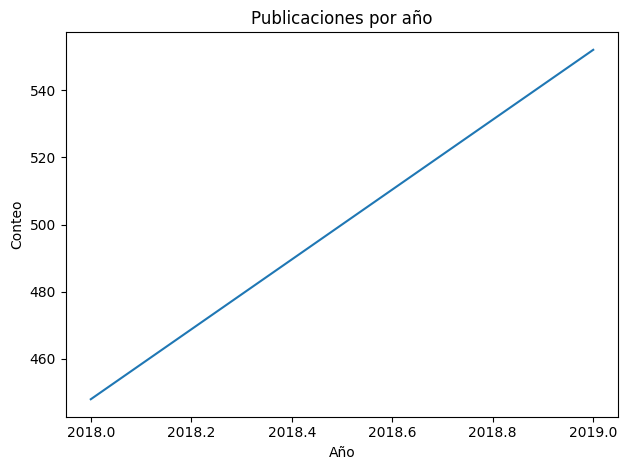

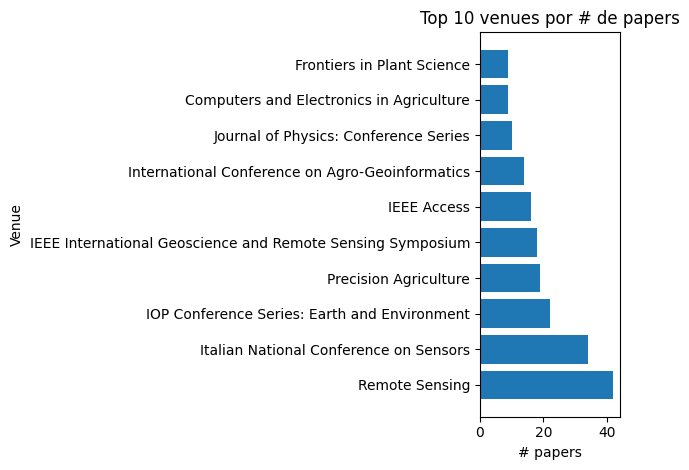

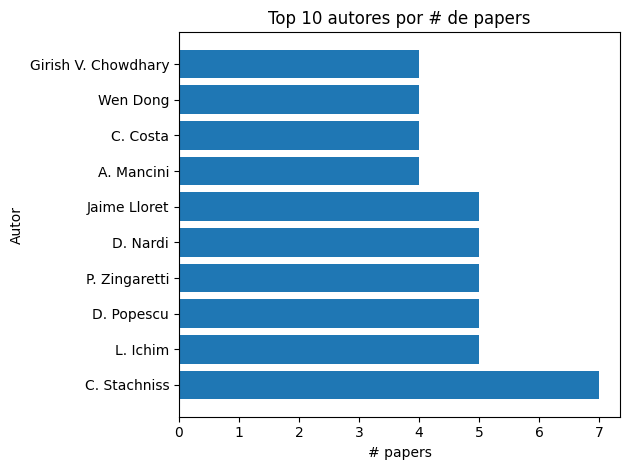

In [16]:
import matplotlib.pyplot as plt

summaries = build_summaries(dfs)

for k, v in summaries.items():
    print(f"\n=== {k} ===")
    display(v.head(10))

if not df_search.empty and "publicationTypes" in df_search.columns:
    print("\n=== Distribución por publicationTypes ===")
    pubtypes = df_search["publicationTypes"].str.get_dummies(sep=",").sum().sort_values(ascending=False)
    display(pubtypes.to_frame("count").head(10))

if not dfs["papers"].empty and "influentialCitationCount" in dfs["papers"].columns:
    print("\n=== Top papers por influentialCitationCount ===")
    top_influential = dfs["papers"][["title", "influentialCitationCount", "year"]].dropna(subset=["influentialCitationCount"])\
        .sort_values("influentialCitationCount", ascending=False).head(20)
    display(top_influential)

if "summary_year_counts" in summaries and not summaries["summary_year_counts"].empty:
    s = summaries["summary_year_counts"].sort_values("year")
    plt.figure()
    plt.plot(s["year"], s["count"])
    plt.title("Publicaciones por año")
    plt.xlabel("Año")
    plt.ylabel("Conteo")
    plt.tight_layout()
    plt.show()

if "summary_top_venues" in summaries and not summaries["summary_top_venues"].empty:
    s = summaries["summary_top_venues"].head(10)
    plt.figure()
    plt.barh(s["name"], s["papers"])
    plt.title("Top 10 venues por # de papers")
    plt.xlabel("# papers")
    plt.ylabel("Venue")
    plt.tight_layout()
    plt.show()

if "summary_top_authors" in summaries and not summaries["summary_top_authors"].empty:
    s = summaries["summary_top_authors"].head(10)
    plt.figure()
    plt.barh(s["name"], s["papers"])
    plt.title("Top 10 autores por # de papers")
    plt.xlabel("# papers")
    plt.ylabel("Autor")
    plt.tight_layout()
    plt.show()



In [17]:
print("=== COBERTURA ===")
print("Candidatos (search):", len(df_search))
print("Detalles (descargados):", len(details), " >= 1000 ?", len(details) >= 1000)

print("\n=== CAMPOS CLAVE ===")
req_cols = ["paperId","title","year","publicationTypes","venue","citationCount","influentialCitationCount","doi","url"]
missing = [c for c in req_cols if c not in dfs["papers"].columns]
print("Faltantes en papers:", missing if missing else " Todos los campos presentes")

print("\n=== GRAFO CITES ===")
e = dfs["paper_cites_paper"]
print("Aristas CITES:", len(e))
print("Self-edges:", (e["sourcePaperId"] == e["targetPaperId"]).sum())
print("Duplicados:", e.duplicated(["sourcePaperId","targetPaperId"]).sum())

papers_set = set(dfs["papers"]["paperId"])
print("Sources fuera de nodos:", (~e["sourcePaperId"].isin(papers_set)).sum())
print("Targets fuera de nodos:", (~e["targetPaperId"].isin(papers_set)).sum())

print("\n=== CONECTIVIDAD ===")
citing = set(e["sourcePaperId"]) & papers_set
cited  = set(e["targetPaperId"]) & papers_set
print("Papers con ≥1 referencia:", len(citing), f"({len(citing)/len(papers_set):.1%})")
print("Papers citados por otro:", len(cited),  f"({len(cited)/len(papers_set):.1%})")

print("\n=== TIPOS DE DOCUMENTO ===")
pubtypes = dfs["papers"]["publicationTypes"].fillna("").str.get_dummies(sep=",").sum().sort_values(ascending=False)
display(pubtypes.to_frame("count").head(10))

print("\n=== TOP INFLUYENTES ===")
display(
    dfs["papers"][["title","influentialCitationCount","year"]]
      .dropna(subset=["influentialCitationCount"])
      .sort_values("influentialCitationCount", ascending=False)
      .head(15)
)



=== COBERTURA ===
Candidatos (search): 1000
Detalles (descargados): 1000  >= 1000 ? True

=== CAMPOS CLAVE ===
Faltantes en papers:  Todos los campos presentes

=== GRAFO CITES ===
Aristas CITES: 14768
Self-edges: 0
Duplicados: 0
Sources fuera de nodos: 0
Targets fuera de nodos: 0

=== CONECTIVIDAD ===
Papers con ≥1 referencia: 327 (2.4%)
Papers citados por otro: 12814 (93.2%)

=== TIPOS DE DOCUMENTO ===


,count
JournalArticle,601
Review,327
Conference,302
Book,20
Study,2
CaseReport,2
Editorial,1
LettersAndComments,1



=== TOP INFLUYENTES ===


,title,influentialCitationCount,year
100,Unmanned Aerial Vehicles (UAVs): A Survey on C...,45,2018
610,CRISPR/Cas Genome Editing and Precision Plant ...,40,2019
251,Machine learning approaches for crop yield pre...,24,2018
408,Optimization approaches for civil applications...,24,2018
177,Fully Convolutional Networks With Sequential I...,21,2018
858,A Survey on LoRa Networking: Research Problems...,20,2019
235,WeedMap: A large-scale semantic weed mapping f...,18,2018
379,Internet of Things (IoT) for Smart Precision A...,17,2018
71,Vegetation Indices Combining the Red and Red-E...,16,2018
849,Plant disease identification using explainable...,16,2019


In [18]:

print("=== ENRIQUECIMIENTO DE AFILIACIONES ===\n")

author_counts = dfs["paper_authoredby_author"]["authorId"].value_counts()
top_n = 200  
top_author_ids = author_counts.head(top_n).index.tolist()

print(f"  Top {top_n} autores más prolíficos identificados")
print(f"   Total de autores únicos: {len(dfs['authors'])}")
print(f"   Enriqueciendo afiliaciones para los top {top_n}...")

import time
import random
from tqdm import tqdm

author_details = []
affiliations_data = []

for author_id in tqdm(top_author_ids, desc="Obteniendo afiliaciones"):
    r = client.get_author_details(author_id)
    if r.status_code == 200 and isinstance(r.data, dict):
        author_details.append(r.data)
        
        affiliations = r.data.get("affiliations", [])
        if affiliations:
            for aff in affiliations:
                affiliations_data.append({
                    "authorId": author_id,
                    "affiliation": aff
                })
    
    time.sleep(0.3 + random.random() * 0.2)

df_affiliations = pd.DataFrame(affiliations_data)

from pathlib import Path
output_dir = Path("data/processed")
output_dir.mkdir(parents=True, exist_ok=True)

if not df_affiliations.empty:
    aff_path = output_dir / "author_affiliations.csv"
    df_affiliations.to_csv(aff_path, index=False, encoding="utf-8")
    print(f"\nAfiliaciones guardadas: {aff_path}")
    print(f"   Total de registros autor-afiliación: {len(df_affiliations)}")
    print(f"   Autores con afiliación: {df_affiliations['authorId'].nunique()}")
    
    # Mostrar ejemplos
    print("\nEjemplos de afiliaciones:")
    sample = df_affiliations.head(10)
    for _, row in sample.iterrows():
        author_name = dfs["authors"][dfs["authors"]["authorId"] == row["authorId"]]["name"].iloc[0] if not dfs["authors"][dfs["authors"]["authorId"] == row["authorId"]].empty else "Unknown"
        print(f"   - {author_name}: {row['affiliation']}")
else:
    print("\nNo se obtuvieron afiliaciones (puede que la API no las exponga en tu versión)")

# 5. Actualizar dfs con los detalles de autor enriquecidos
if author_details:
    df_authors_enriched = pd.DataFrame([{
        "authorId": a.get("authorId"),
        "name": a.get("name"),
        "url": a.get("url"),
        "paperCount": a.get("paperCount"),
        "citationCount": a.get("citationCount")
    } for a in author_details])
    
    enriched_path = output_dir / "authors_enriched.csv"
    df_authors_enriched.to_csv(enriched_path, index=False, encoding="utf-8")
    print(f"\nDetalles de autores enriquecidos guardados: {enriched_path}")
    
print("\nEnriquecimiento completado")


=== ENRIQUECIMIENTO DE AFILIACIONES ===

  Top 200 autores más prolíficos identificados
   Total de autores únicos: 3872
   Enriqueciendo afiliaciones para los top 200...


Obteniendo afiliaciones: 100%|██████████| 200/200 [03:33<00:00,  1.07s/it]


Afiliaciones guardadas: data\processed\author_affiliations.csv
   Total de registros autor-afiliación: 7
   Autores con afiliación: 6

Ejemplos de afiliaciones:
   - Jaime Lloret: Universitat Politecnica de Valencia
   - Mohand Tahar Kechadi: University College Dublin
   - Alfonso F. Torres-Rua: Utah State University
   - Abdul Salam: Purdue University
   - Paolo Remagnino: Kingston University
   - I. Oseledets: AIRI
   - I. Oseledets: Skoltech

Detalles de autores enriquecidos guardados: data\processed\authors_enriched.csv

Enriquecimiento completado


In [20]:
import subprocess
from pathlib import Path

try:
    notebook_path = Path("notebooks/01_extraccion_precision_agri.ipynb")
    
    if not notebook_path.exists() and Path("01_extraccion_precision_agri.ipynb").exists():
        notebook_path = Path("01_extraccion_precision_agri.ipynb")
    
    print(f"Notebook a exportar: {notebook_path}")
    
    if notebook_path.exists():
        output_path = notebook_path.with_suffix('.html')
        
        print(f"Exportando a HTML...")
        print(f"   Destino: {output_path}")
        
        result = subprocess.run(
            ["jupyter", "nbconvert", "--to", "html", str(notebook_path)],
            capture_output=True,
            text=True
        )
        
        if result.returncode == 0:
            print(f"\n¡Exportación exitosa!")
            print(f"   Archivo generado: {output_path.name}")
            print(f"   Ubicación completa: {output_path.absolute()}")
            print(f"\nAbre el HTML en tu navegador para ver el resultado final")
        else:
            print(f"Error en la exportación:")
            print(result.stderr)
            print("\nAlternativa: Ejecuta manualmente desde la terminal:")
            print(f"   jupyter nbconvert --to html {notebook_path}")
    else:
        print(f"No se encontró el notebook en: {notebook_path}")
        print("\nEjecuta manualmente desde la terminal:")
        print("   cd notebooks")
        print("   jupyter nbconvert --to html 01_extraccion_precision_agri.ipynb")

except Exception as e:
    print(f"No se pudo exportar automáticamente: {e}")
    print("\nExporta manualmente usando una de estas opciones:")
    print("\nOpción 1 - Línea de comandos:")
    print("   jupyter nbconvert --to html notebooks/01_extraccion_precision_agri.ipynb")
    print("\nOpción 2 - VS Code:")
    print("   1. Click en '...' en la barra superior del notebook")
    print("   2. Selecciona 'Export' → 'HTML'")
    print("   3. Guarda como '01_extraccion_precision_agri.html'")


Notebook a exportar: 01_extraccion_precision_agri.ipynb
Exportando a HTML...
   Destino: 01_extraccion_precision_agri.html
No se pudo exportar automáticamente: [WinError 2] El sistema no puede encontrar el archivo especificado

Exporta manualmente usando una de estas opciones:

Opción 1 - Línea de comandos:
   jupyter nbconvert --to html notebooks/01_extraccion_precision_agri.ipynb

Opción 2 - VS Code:
   1. Click en '...' en la barra superior del notebook
   2. Selecciona 'Export' → 'HTML'
   3. Guarda como '01_extraccion_precision_agri.html'


In [32]:
import pandas as pd
import re
import unicodedata
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import RDF, RDFS, XSD
from pathlib import Path

# Ajuste de rutas para el Notebook
# Asumiendo que el notebook corre en notebooks/ y data está en notebooks/data
DATA = Path("data/processed")
OUT = Path("out")
OUT.mkdir(parents=True, exist_ok=True)

print(f"📂 Directorio de datos: {DATA.absolute()}")
print(f"📂 Directorio de salida: {OUT.absolute()}")

# Prefijos / Namespaces
EX = Namespace("http://example.org/agri#")
SCHEMA = Namespace("http://schema.org/")
DCT = Namespace("http://purl.org/dc/terms/")
SKOS = Namespace("http://www.w3.org/2004/02/skos/core#")

g = Graph()
g.bind("ex", EX)
g.bind("schema", SCHEMA)
g.bind("dct", DCT)
g.bind("skos", SKOS)
g.bind("rdfs", RDFS)

# --- Utilidades ---
def slugify_safe(text):
    """Convierte texto a formato slug seguro para URIs (compatible Python 3)."""
    if text is None:
        return "unknown"
    # Normalizar unicode
    text = unicodedata.normalize('NFKD', str(text))
    # Convertir a ASCII, ignorar caracteres no ASCII
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Convertir a minúsculas
    text = text.lower()
    # Reemplazar caracteres no alfanuméricos por guiones
    text = re.sub(r'[^\w\s-]', '', text)
    # Reemplazar espacios y guiones múltiples por un solo guion
    text = re.sub(r'[-\s]+', '-', text)
    # Eliminar guiones al inicio y final
    text = text.strip('-')
    # Si queda vacío, usar "unknown"
    return text if text else "unknown"

def U(kind, raw_id):
    """Crea un URIRef desde un tipo y un ID raw."""
    return URIRef(f"{EX}{kind}-{slugify_safe(raw_id)}")

def add_lit(s, p, val, dtype=None):
    """Añade un literal si no es NaN."""
    if pd.isna(val):
        return
    if dtype:
        g.add((s, p, Literal(val, datatype=dtype)))
    else:
        g.add((s, p, Literal(val)))

# --- Carga CSVs ---
print("📂 Cargando CSVs...")
try:
    papers = pd.read_csv(DATA / "papers.csv")
    authors = pd.read_csv(DATA / "authors.csv")
    venues = pd.read_csv(DATA / "venues.csv")
    fields = pd.read_csv(DATA / "fields.csv")
    pa = pd.read_csv(DATA / "paper_authoredby_author.csv")
    pv = pd.read_csv(DATA / "paper_publishedin_venue.csv")
    pt = pd.read_csv(DATA / "paper_has_topic.csv")
    pc = pd.read_csv(DATA / "paper_cites_paper.csv")
except FileNotFoundError as e:
    print(f"❌ Error al cargar archivos CSV: {e}")
    # En notebook no usamos sys.exit, mejor lanzar error o parar
    raise e

# author_affiliations puede no existir o estar vacío
aff_path = DATA / "author_affiliations.csv"
if aff_path.exists():
    aff = pd.read_csv(aff_path)
    print(f"   Afiliaciones encontradas: {len(aff)} registros")
else:
    aff = pd.DataFrame(columns=["authorId", "affiliation"])
    print("   ⚠️ author_affiliations.csv no encontrado (opcional)")

# Cargar autores enriquecidos si existe
auth_enriched_path = DATA / "authors_enriched.csv"
if auth_enriched_path.exists():
    authors_enriched = pd.read_csv(auth_enriched_path)
    # Merge para tener las métricas en el dataframe principal de autores
    # Usamos how='left' para mantener todos los autores originales
    authors = authors.merge(authors_enriched[['authorId', 'paperCount', 'citationCount']], on='authorId', how='left')
    print(f"   Autores enriquecidos cargados: {len(authors_enriched)} registros")
else:
    print("   ⚠️ authors_enriched.csv no encontrado (métricas de autor no disponibles)")

print(f"   Papers: {len(papers)}, Authors: {len(authors)}, Venues: {len(venues)}, Fields: {len(fields)}")

# --- Papers como schema:Article ---
print("\n📄 Procesando papers...")
for _, r in papers.iterrows():
    A = U("art", r["paperId"])
    g.add((A, RDF.type, SCHEMA.Article))
    add_lit(A, SCHEMA.identifier, r.get("paperId"))
    add_lit(A, SCHEMA.title, r.get("title"))
    add_lit(A, SCHEMA.description, r.get("abstract"))
    
    if pd.notna(r.get("publicationDate")):
        add_lit(A, SCHEMA.datePublished, r.get("publicationDate"), XSD.date)
    elif pd.notna(r.get("year")): # Fallback al año si no hay fecha completa
        add_lit(A, SCHEMA.datePublished, str(int(r.get("year"))), XSD.gYear)
        
    add_lit(A, SCHEMA.doi, r.get("doi"))
    
    # Métricas de paper (Nuevos campos)
    if pd.notna(r.get("citationCount")):
        add_lit(A, EX.citationCount, int(r.get("citationCount")), XSD.integer)
    if pd.notna(r.get("influentialCitationCount")):
        add_lit(A, EX.influentialCitationCount, int(r.get("influentialCitationCount")), XSD.integer)

    if pd.notna(r.get("url")):
        try:
            g.add((A, SCHEMA.url, URIRef(r["url"])))
        except:
            pass  # Si la URL no es válida, la saltamos

# --- Authors como schema:Person ---
print("👤 Procesando authors...")
for _, r in authors.iterrows():
    P = U("person", r["authorId"])
    g.add((P, RDF.type, SCHEMA.Person))
    add_lit(P, SCHEMA.identifier, r.get("authorId"))
    add_lit(P, SCHEMA.name, r.get("name"))
    
    # Métricas de autor (si existen tras el merge)
    if "paperCount" in r and pd.notna(r.get("paperCount")):
        add_lit(P, EX.paperCount, int(r.get("paperCount")), XSD.integer)
    if "citationCount" in r and pd.notna(r.get("citationCount")):
        add_lit(P, EX.citationCount, int(r.get("citationCount")), XSD.integer)

    if pd.notna(r.get("url")):
        try:
            g.add((P, SCHEMA.url, URIRef(r["url"])))
        except:
            pass

# --- Venues como schema:Periodical ---
print("📚 Procesando venues...")
for _, r in venues.iterrows():
    V = U("periodical", r["venueId"])
    g.add((V, RDF.type, SCHEMA.Periodical))
    add_lit(V, SCHEMA.identifier, r.get("venueId"))
    add_lit(V, SCHEMA.name, r.get("name"))

# --- Fields/Topics como skos:Concept ---
print("🔬 Procesando fields...")
for _, r in fields.iterrows():
    C = U("concept", r["fieldName"])
    g.add((C, RDF.type, SKOS.Concept))
    add_lit(C, SKOS.prefLabel, r.get("fieldName"))

# --- Relaciones: AUTHORED_BY, PUBLISHED_IN, HAS_TOPIC ---
print("🔗 Procesando relaciones...")
for _, r in pa.iterrows():
    A = U("art", r["paperId"])
    P = U("person", r["authorId"])
    g.add((A, SCHEMA.author, P))

for _, r in pv.iterrows():
    A = U("art", r["paperId"])
    V = U("periodical", r["venueId"])
    g.add((A, SCHEMA.isPartOf, V))

for _, r in pt.iterrows():
    A = U("art", r["paperId"])
    C = U("concept", r["fieldName"])  # Usa fieldName, no fieldId
    g.add((A, DCT.subject, C))

# --- CITES ---
print("📎 Procesando citas...")
for _, r in pc.iterrows():
    S = U("art", r["sourcePaperId"])
    T = U("art", r["targetPaperId"])
    g.add((S, SCHEMA.citation, T))
    
    # Asegurar que el target también esté tipado como Article
    # Esto "valida" que la referencia sea un nodo válido en el grafo
    g.add((T, RDF.type, SCHEMA.Article))

# --- Afiliaciones: Organization (simplificado - solo affiliation string) ---
if not aff.empty:
    print("🏢 Procesando afiliaciones...")
    for _, r in aff.iterrows():
        P = U("person", r["authorId"])
        aff_name = r.get("affiliation")
        if pd.notna(aff_name):
            # Crear organización desde el nombre de afiliación
            O = U("org", aff_name)
            g.add((O, RDF.type, SCHEMA.Organization))
            add_lit(O, SCHEMA.name, aff_name)
            g.add((P, SCHEMA.affiliation, O))

# --- Guardar ---
ttl_path = OUT / "agri_graph.ttl"
g.serialize(ttl_path, format="turtle")
print(f"\n✅ RDF generado: {ttl_path}")
print(f"   Triples: {len(g)}")
print(f"   Tamaño: {ttl_path.stat().st_size / 1024 / 1024:.2f} MB")

# También guardar en formato N-Triples (opcional)
nt_path = OUT / "agri_graph.nt"
g.serialize(nt_path, format="nt")
print(f"✅ N-Triples generado: {nt_path}")
print(f"   Tamaño: {nt_path.stat().st_size / 1024 / 1024:.2f} MB")


📂 Cargando CSVs...
   Afiliaciones encontradas: 7 registros
   Papers: 13747, Authors: 3872, Venues: 541, Fields: 16

📄 Procesando papers...
👤 Procesando authors...
📚 Procesando venues...
🔬 Procesando fields...
🔗 Procesando relaciones...
📎 Procesando citas...
🏢 Procesando afiliaciones...

✅ RDF generado: out\agri_graph.ttl
   Triples: 65774
   Tamaño: 4.69 MB


c:\Users\villa\OneDrive\Documentos\Bim1InteroperabilidadDatos-main\.venv\Lib\site-packages\rdflib\plugins\serializers\nt.py:39: UserWarning: NTSerializer always uses UTF-8 encoding. Given encoding was: None
  warnings.warn(


✅ N-Triples generado: out\agri_graph.nt
   Tamaño: 10.39 MB


# 📊 Exportación RDF y Carga en GraphDB

## Instrucciones para GraphDB

### 1. Crear Repositorio
1. Abre GraphDB
2. Ve a **Repositories** → **Create**
3. Nombre: `agri-precision`
4. Acepta los valores por defecto (RDF4J, OWL-Horst, etc.)
5. Click en **Create**

### 2. Configurar Prefijos
1. Ve a **Settings** → **Namespaces**
2. Añade los siguientes prefijos si no existen:
   - `ex` → `http://example.org/agri#`
   - `schema` → `http://schema.org/`
   - `dct` → `http://purl.org/dc/terms/`
   - `skos` → `http://www.w3.org/2004/02/skos/core#`

### 3. Importar RDF
1. Ve a **Import** → **Local files**
2. Selecciona `out/agri_graph.ttl`
3. Click en **Import**
4. **📸 Toma captura** de la pantalla "Import successful" (muestra el conteo de triples)

### 4. Visualizar Grafo
1. Ve a **Explore** → **Visual graph**
2. Busca `schema:Article` y activa auto-expand
3. Verás nodos de Article → Person → Periodical → Concept
4. **📸 Toma 1-2 capturas** del grafo visual

---

## Consultas SPARQL para el Informe

Ejecuta estas consultas en GraphDB (SPARQL → Query) y **toma capturas** de los resultados:

### A. Artículos con autores, venue y conceptos

```sparql
PREFIX schema: <http://schema.org/>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX skos:   <http://www.w3.org/2004/02/skos/core#>

SELECT ?art ?title ?author ?venue ?concept
WHERE {
  ?a a schema:Article ; schema:title ?title .
  OPTIONAL { ?a schema:author / schema:name ?author }
  OPTIONAL { ?a schema:isPartOf / schema:name ?venue }
  OPTIONAL { ?a dct:subject / skos:prefLabel ?concept }
  BIND(STR(?a) AS ?art)
}
LIMIT 25
```

### B. Top conceptos por cantidad de artículos

```sparql
PREFIX schema: <http://schema.org/>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX skos:   <http://www.w3.org/2004/02/skos/core#>

SELECT ?concept ?label (COUNT(?a) AS ?n)
WHERE {
  ?a a schema:Article ; dct:subject ?c .
  ?c skos:prefLabel ?label .
  BIND(STR(?c) AS ?concept)
}
GROUP BY ?concept ?label
ORDER BY DESC(?n)
LIMIT 10
```

### C. Citas (paper → paper)

```sparql
PREFIX schema: <http://schema.org/>

SELECT ?fromTitle ?toTitle
WHERE {
  ?from a schema:Article ; schema:citation ?to ;
        schema:title ?fromTitle .
  OPTIONAL { ?to schema:title ?toTitle }
}
LIMIT 25
```

---

## 📸 Capturas Necesarias para el Informe

1. **Repositorio creado** (`agri-precision`)
2. **Import success** (conteo de triples)
3. **Visual Graph** con Article–Person–Periodical–Concept
4. **Resultados de consulta A** (tabla con artículos, autores, venues, conceptos)
5. **Resultados de consulta B** (tabla con top conceptos)
6. **Resultados de consulta C** (tabla con citas)

---

## Checklist Final

- [ ] Ejecuté la celda anterior y se generó `out/agri_graph.ttl`
- [ ] Creé repositorio `agri-precision` en GraphDB
- [ ] Importé `agri_graph.ttl` sin errores (captura tomada)
- [ ] Configuré los prefijos en GraphDB
- [ ] Corrí las consultas A/B/C en SPARQL y tomé capturas
- [ ] Añadí las imágenes al informe PDF
- [ ] Exporté el notebook a HTML (celda 11)
